In [58]:
import tensorflow as tf
import numpy as np
import random
import time
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [3]:
def set_global_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    tf.random.set_seed(seed_val)

In [4]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
    
        # Block 1
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.DepthwiseConv2D(3, padding="same", activation="relu", depth_multiplier=2),
        tf.keras.layers.Dropout(0.1),
    
        # Block 2
        tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
    
        # Block 3
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.DepthwiseConv2D(3, padding="same", activation="relu", depth_multiplier=2),
        tf.keras.layers.Dropout(0.3),
    
        # Block 4
        tf.keras.layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.DepthwiseConv2D(3, padding="same", activation="relu"),
        tf.keras.layers.Dropout(0.3),
    
        # Block 5
        tf.keras.layers.Conv2D(512, 3, activation="relu", strides=2, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
    
        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation="softmax"),
    ])
    
    return model

In [5]:
BATCH_SIZE = 32

# Create a tf.data.Dataset from the variables
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(10/360, fill_mode="nearest"),
    tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest")
])

# Apply data augmentation to the dataset
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE  # Enable parallel processing
)

# # Create an additional dataset that contains 50% of the original dataset
# additional_data = train_dataset.take(int(np.ceil(len(X_train)*.5/BATCH_SIZE))).map(
#     lambda x, y: (data_augmentation(x, training=True), y),
#     num_parallel_calls=tf.data.AUTOTUNE
# )
# augmented_train_dataset = augmented_train_dataset.concatenate(additional_data)

# Add prefetching for performance
augmented_train_dataset = augmented_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
total_time_taken = 0
initial_epoch = 0
# Model creation and compilation
set_global_seed(42)
model = create_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [50]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_accuracy', mode='max'):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = None
        self.latest_checkpoint = None

        # Ensure the directory exists (if any directory is part of the path)
        directory = os.path.dirname(filepath)
        if directory:  # Only create if directory is specified
            os.makedirs(directory, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        
        # Get the monitored metric
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Determine whether the metric improved
        if self.best is None or (self.mode == 'max' and current > self.best) or (self.mode == 'min' and current < self.best):
            self.best = current
            
            # Format the filepath with epoch and metric values
            filename = self.filepath.format(epoch=epoch+1, **logs)
            
            # Save the new model
            self.model.save(filename)
            
            # Delete the previous checkpoint after saving the new one
            if self.latest_checkpoint and os.path.exists(self.latest_checkpoint):
                os.remove(self.latest_checkpoint)
            
            # Update the latest checkpoint
            self.latest_checkpoint = filename

# Usage example
custom_checkpoint = CustomModelCheckpoint(
    filepath='best_model_epoch_{epoch:03d}_val_acc_{val_accuracy:.4f}.keras',
    monitor='val_accuracy',
    mode='max'
)

In [53]:
epochs = 200
start_time = time.time()
history = model.fit(augmented_train_dataset, validation_data=(X_test, y_test), 
                    epochs=epochs, initial_epoch=initial_epoch, callbacks=[custom_checkpoint])
end_time = time.time()
total_time_taken += (end_time-start_time)
initial_epoch = epochs
print(f"\nModel trained for {epochs} epochs in {round(total_time_taken/60, 2)} minutes.")

Epoch 151/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9304 - loss: 0.2049 - val_accuracy: 0.8995 - val_loss: 0.3340
Epoch 152/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9314 - loss: 0.2000 - val_accuracy: 0.8945 - val_loss: 0.3444
Epoch 153/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9305 - loss: 0.2022 - val_accuracy: 0.9002 - val_loss: 0.3240
Epoch 154/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9316 - loss: 0.1974 - val_accuracy: 0.8986 - val_loss: 0.3289
Epoch 155/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9341 - loss: 0.1924 - val_accuracy: 0.9008 - val_loss: 0.3248
Epoch 156/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9312 - loss: 0.1991 - val_accuracy: 0.8981 - val_loss: 0.3425
Epoch 157/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9324 - loss: 0.1951 - val_accuracy: 0.9040 - val_loss: 0.3134
Epoch 158/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/s

## Plotting Accuracy and Loss Curves

In [56]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

In [60]:
len(train_acc)

50

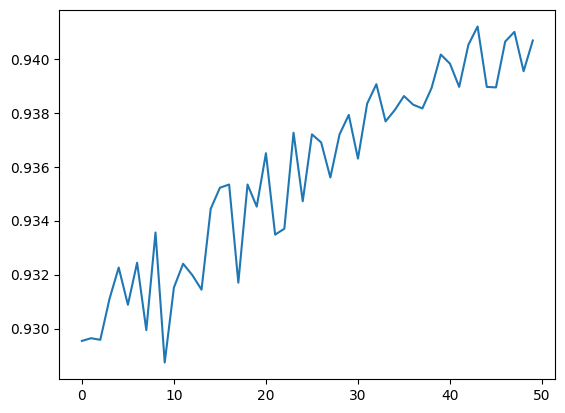

In [59]:
plt.plot(range(len(train_acc)), train_acc)
plt.show()